In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import seaborn as sns
from tabulate import tabulate
from datetime import date, datetime, timedelta
import holidays 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
Month = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
         7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
Seasons = {1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',
         7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn',12:'Winter'}
DayName = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
WeekDayWeekend = {0:'Weekday',1:'Weekday',2:'Weekday',3:'Weekday',4:'Weekday',5:'WeekEnd',6:'WeekEnd'}
MonthlyDaylight = {1:8.4,2:10.1,3:11.9,4:14.0,5:15.7,6:16.7,\
                   7:16.2,8:14.7,9:12.7,10:10.8,11:8.9,12:7.9} # SOURCE: https://www.worlddata.info/europe/united-kingdom/sunset.php

In [3]:
EndYear = 2022
AllHolidays = {}
for Year in range (2009,EndYear+1):
    GBHolidays = holidays.UnitedKingdom(subdiv='ENG',years=Year,observed=False)\
                + holidays.UnitedKingdom(subdiv='SCT',years=Year,observed=False)\
                + holidays.UnitedKingdom(subdiv='WLS',years=Year,observed=False)
    #
    for days in GBHolidays.items():
        AllHolidays[days[0]] = days[1]

In [4]:
# For Hourly
HourlyDF = pd.read_csv("0.DataSource/National Demand/df_fuel_ckan_DemandPriceTemp_Hourly.csv")
HourlyDF['DATETIME'] = pd.to_datetime(HourlyDF['DATETIME'])
HourlyDF['Date'] = pd.to_datetime(HourlyDF['DATETIME']).dt.date
HourlyDF = HourlyDF.loc[(HourlyDF['DATETIME'].dt.year >= 2009) & (HourlyDF['DATETIME'].dt.year <= EndYear)]
#
#
HourlyDF['Year'],HourlyDF['Quarter'],HourlyDF['Month'],HourlyDF['Day'],HourlyDF['WeekNumber'],HourlyDF['DaysOfTheYear'],\
    HourlyDF['DayOfTheWeek'],HourlyDF['Hour'] = HourlyDF['DATETIME'].dt.year,HourlyDF['DATETIME'].dt.quarter,\
    HourlyDF['DATETIME'].dt.month,HourlyDF['DATETIME'].dt.day,HourlyDF['DATETIME'].dt.isocalendar().week,\
    HourlyDF['DATETIME'].dt.dayofyear,HourlyDF['DATETIME'].dt.dayofweek,HourlyDF['DATETIME'].dt.hour
HourlyDF['Seasons'] = HourlyDF['Month'].map(Seasons)
HourlyDF['WeekDay_OR_Weekend'] = HourlyDF['DayOfTheWeek'].map(WeekDayWeekend)
HourlyDF['PublicHoliday'] = HourlyDF['Date'].map(AllHolidays)

In [5]:
HourlyDF.columns

Index(['DATETIME', 'MC_StartingVolume', 'SBP(GBP/MWh)', 'SSP(GBP/MWh)',
       'MID_APX_VOLUME(MWh)', 'MID_APX_PRICE(GBP/MWh)', 'MID_N2EX_VOLUME(MWh)',
       'MID_N2EX_PRICE(GBP/MWh)', 'SSP_(GBP/MWh)', 'NIV(MWh)',
       'NordPool_HH_Vol(MWh)', 'NordPool_HH_Price(GBP/MWh)',
       'NordPool_DA_H_Vol(MWh)', 'NordPool_DA_H_Price(GBP/MWh)',
       'Air_Temperature', 'GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS',
       'BIOMASS', 'OTHER', 'SOLAR', 'STORAGE', 'GENERATION',
       'CARBON_INTENSITY', 'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL',
       'GAS_perc', 'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'HYDRO_perc',
       'IMPORTS_perc', 'BIOMASS_perc', 'OTHER_perc', 'SOLAR_perc',
       'STORAGE_perc', 'GENERATION_perc', 'LOW_CARBON_perc',
       'ZERO_CARBON_perc', 'RENEWABLE_perc', 'FOSSIL_perc',
       'ENGLAND_WALES_DEMAND', 'TRANSMISSION_SYSTEM_DEMAND', 'NATIONAL DEMAND',
       'ProfileAPlanB_A2A_0Per_HP_Only_Demand',
       'ProfileAPlanB_A2A_0Per_COMBINED Demand',

In [6]:
Target = "SBP(GBP/MWh)"
path = './4.Results/1.XGB_Results/3_CV_SBP_Price'

In [7]:
SelectedColumns = ['DATETIME',
    Target,'Year','Quarter','Month', 'Day','WeekNumber','DaysOfTheYear','DayOfTheWeek','Hour','Seasons','Air_Temperature','WeekDay_OR_Weekend','PublicHoliday',
    'CARBON_INTENSITY', 'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL','GAS_perc', 'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'HYDRO_perc',
    'IMPORTS_perc', 'BIOMASS_perc', 'OTHER_perc', 'SOLAR_perc','STORAGE_perc', 'GENERATION_perc', 'LOW_CARBON_perc','ZERO_CARBON_perc', 'RENEWABLE_perc', 'FOSSIL_perc','NATIONAL DEMAND',                   
                  ]                                                                         # For the model.
SelectedDF = HourlyDF[SelectedColumns].copy()

In [8]:
TemperaturePercentiles = {}
for Year in range(2009,EndYear+1):
    YearlyTempvalues = SelectedDF.loc[(SelectedDF["Year"] == Year)]['Air_Temperature']
    Val25,Val75 = np.percentile(YearlyTempvalues, [25,75])
    TemperaturePercentiles[Year]=[Val25,Val75]

In [9]:
LogFile = open(f"{path}/LogFile.log",mode="w")
print("=================================================\nFor Target: ",Target,file=LogFile)

In [10]:
SelectedDF['Year'] = SelectedDF['Year'].astype('uint16')
SelectedDF['DaysOfTheYear'] = SelectedDF['DaysOfTheYear'].astype('uint16')
SelectedDF['Quarter'] = SelectedDF['Quarter'].astype('uint8')
SelectedDF['Month'] = SelectedDF['Month'].astype('uint8')
SelectedDF['Day'] = SelectedDF['Day'].astype('uint8')
SelectedDF['WeekNumber'] = SelectedDF['WeekNumber'].astype('uint8')
SelectedDF['DayOfTheWeek'] = SelectedDF['DayOfTheWeek'].astype('uint8')
SelectedDF['Hour'] = SelectedDF['Hour'].astype('uint8')
SelectedDF = pd.get_dummies(SelectedDF,drop_first=True)
SelectedDF = SelectedDF.set_index('DATETIME')
SelectedDF = SelectedDF.sort_index()

In [11]:
# This contains the CrossValidation Stuff

In [12]:
from sklearn.model_selection import TimeSeriesSplit
numberofsplit = 7
TSS = TimeSeriesSplit(n_splits=numberofsplit, test_size=24*365*1, gap=24)

In [13]:
fig, axs = plt.subplots(numberofsplit, 1, figsize=(15, 2.5*numberofsplit), sharex=True)
fold = 0
for train_idx, val_idx in TSS.split(SelectedDF):
    train = SelectedDF.iloc[train_idx]
    test = SelectedDF.iloc[val_idx]
    train[Target].plot(ax=axs[fold],label='Training Set',title=f'Cross Validation data Train/Test split {fold+1}.',grid=True,ylabel=Target)
    test[Target].plot(ax=axs[fold],label='Test Set',grid=True)
    fold += 1
plt.tight_layout()
plt.savefig(f"{path}/0_TestingYears.png")
plt.close('all')

In [14]:
# What was it like this hour/day of the week previous 1, 2 and 3 years ago - to give it a bit of a weighting factor.
def AddLagsHours(df):
    TargetMap = df[Target].to_dict()
    df['OneYearLag'] = (df.index - pd.Timedelta('364 days')).map(TargetMap)
    df['TwoYearLag'] = (df.index - pd.Timedelta('728 days')).map(TargetMap)
    df['ThreeYearLag'] = (df.index - pd.Timedelta('1092 days')).map(TargetMap)
    df['FourYearLag'] = (df.index - pd.Timedelta('1456 days')).map(TargetMap)
    df['FiveYearLag'] = (df.index - pd.Timedelta('1820 days')).map(TargetMap)
    return df

In [15]:
SelectedDF = AddLagsHours(SelectedDF)

In [16]:
SelectedDF.columns

Index(['SBP(GBP/MWh)', 'Year', 'Quarter', 'Month', 'Day', 'WeekNumber',
       'DaysOfTheYear', 'DayOfTheWeek', 'Hour', 'Air_Temperature',
       'CARBON_INTENSITY', 'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL',
       'GAS_perc', 'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'HYDRO_perc',
       'IMPORTS_perc', 'BIOMASS_perc', 'OTHER_perc', 'SOLAR_perc',
       'STORAGE_perc', 'GENERATION_perc', 'LOW_CARBON_perc',
       'ZERO_CARBON_perc', 'RENEWABLE_perc', 'FOSSIL_perc', 'NATIONAL DEMAND',
       'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'WeekDay_OR_Weekend_Weekday', 'PublicHoliday_Christmas Day',
       'PublicHoliday_Diamond Jubilee of Elizabeth II',
       'PublicHoliday_Easter Monday', 'PublicHoliday_Good Friday',
       'PublicHoliday_Late Summer Bank Holiday', 'PublicHoliday_May Day',
       'PublicHoliday_New Year Holiday', 'PublicHoliday_New Year's Day',
       'PublicHoliday_Platinum Jubilee of Elizabeth II',
       'PublicHoliday_Spring Bank Holiday', 

In [17]:
TrainFeatures = ['Year', 'Quarter', 'Month', 'Day', 'WeekNumber',
       'DaysOfTheYear', 'DayOfTheWeek', 'Hour', 'Air_Temperature',
       'CARBON_INTENSITY', 'LOW_CARBON', 'ZERO_CARBON', 'RENEWABLE', 'FOSSIL',
       'GAS_perc', 'COAL_perc', 'NUCLEAR_perc', 'WIND_perc', 'HYDRO_perc',
       'IMPORTS_perc', 'BIOMASS_perc', 'OTHER_perc', 'SOLAR_perc',
       'STORAGE_perc', 'GENERATION_perc', 'LOW_CARBON_perc',
       'ZERO_CARBON_perc', 'RENEWABLE_perc', 'FOSSIL_perc', 'NATIONAL DEMAND',
       'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'WeekDay_OR_Weekend_Weekday', 'PublicHoliday_Christmas Day',
       'PublicHoliday_Diamond Jubilee of Elizabeth II',
       'PublicHoliday_Easter Monday', 'PublicHoliday_Good Friday',
       'PublicHoliday_Late Summer Bank Holiday', 'PublicHoliday_May Day',
       'PublicHoliday_New Year Holiday', "PublicHoliday_New Year's Day",
       'PublicHoliday_Platinum Jubilee of Elizabeth II',
       'PublicHoliday_Spring Bank Holiday', "PublicHoliday_St. Andrew's Day",
       'PublicHoliday_State Funeral of Queen Elizabeth II',
       'PublicHoliday_Summer Bank Holiday',
       'PublicHoliday_Wedding of William and Catherine', 'OneYearLag',
       'TwoYearLag', 'ThreeYearLag', 'FourYearLag', 'FiveYearLag',
           ]

In [18]:
def Features(regimportance,regNames,TestingYear):
    FeatureImportances = pd.DataFrame(data=regimportance,
                 index=regNames,
                 columns=['Importance'])
    FeatureImportances.sort_values('Importance').plot(kind='barh', title=f"Feature Importance, Target '{Target}', Year {TestingYear}",legend=False, figsize=(9,16))
    plt.grid(which='both',linewidth = 0.5)
    plt.tight_layout()
    plt.savefig(f"{path}/1_FeatureImportance_{TestingYear}.png")
    plt.close('all')

In [19]:
def PlotTrainingTestSplit (Train,Test,Label):
    plt.figure(figsize=(20,5))
    sns.lineplot(data=Train,x=Train.index,y=Target,label='Training Set')
    sns.lineplot(data=Test,x=Test.index,y=Target,label='Test Set')
    plt.title(f"Plot of the distribution of Training and Test set, Test year ({TestingYear}).",fontsize=14)
    plt.ylabel(Target,fontsize=14)
    plt.xlabel('DateTime',fontsize=14)
    plt.grid(which='both',linewidth = 0.5)
    plt.ylim(0,)
    plt.tight_layout()
    plt.savefig(f"{path}/2_SplitOfTrainingTestSet_{TestingYear}.png")
    plt.close('all')

In [20]:
def Top10MinMaxErrors (Test,TestingYear):
    # Calculate top 10 min and max errors.
    Test['Error(ABS)'] = np.abs(Test[Target] - Test['PredictedDemand'])
    Test['Error'] = Test[Target] - Test['PredictedDemand']
    ErrorList = Test['Error'].to_list()
    ErrorDict[TestingYear] = ErrorList
    Test['Date'] = Test.index.date
    Top10 = Test.groupby(['Date'])['Error(ABS)'].mean().sort_values(ascending=False).head(10)
    Lowest10 = Test.groupby(['Date'])['Error(ABS)'].mean().sort_values(ascending=False).tail(10)
    #print(f"Worse 10 Error days {TestingYear}:\n",Top10,file=LogFile)
    #print(f"Best 10 Error days {TestingYear}:\n",Lowest10,'\n#################################\n#################################',file=LogFile)
    #
    HighestDiffDate,HighestDiffDayValue = Top10.index[0], Top10[0]
    LowestDiffDate, LowestDiffDayValue = Lowest10.index[-1], Lowest10[-1]
    #
    HighestOffsetPoint = Test[Test['Date'] == HighestDiffDate]['Error(ABS)'].max()
    ActualDemandHighest = Test[(Test['Date'] == HighestDiffDate) & (Test['Error(ABS)'] == HighestOffsetPoint)][Target].values[0]
    PredictedDemandHighest = Test[(Test['Date'] == HighestDiffDate) & (Test['Error(ABS)'] == HighestOffsetPoint)]['PredictedDemand'].values[0]
    WorseErrorRate = round((ActualDemandHighest-PredictedDemandHighest)*100/ActualDemandHighest,1)
    #
    LowestOffsetPoint = Test[Test['Date'] == LowestDiffDate]['Error(ABS)'].max()
    ActualDemandLowest = Test[(Test['Date'] == LowestDiffDate) & (Test['Error(ABS)'] == LowestOffsetPoint)][Target].values[0]
    PredictedDemandLowest = Test[(Test['Date'] == LowestDiffDate) & (Test['Error(ABS)'] == LowestOffsetPoint)]['PredictedDemand'].values[0]
    BestErrorRate = round((ActualDemandLowest-PredictedDemandLowest)*100/ActualDemandLowest,1)
    #
    WorseCaseDF = Test[(Test['Date'] >= HighestDiffDate) & (Test['Date'] <= (HighestDiffDate+timedelta(days=7)))]
    BestCaseDF = Test[(Test['Date'] >= LowestDiffDate) & (Test['Date'] <= (LowestDiffDate+timedelta(days=7)))]
    #
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.lineplot(data=WorseCaseDF,x=WorseCaseDF.index,y=Target,label='Real Demand',markers=True)
    sns.lineplot(data=WorseCaseDF,x=WorseCaseDF.index,y='PredictedDemand',label='Predicted price',markers=True)
    plt.title(f"Test year: {TestingYear}, Worst predicted day ({HighestDiffDate}) and the following week profile.\nDay Mean Error: {int(HighestDiffDayValue)}, GBP/MWh ## Maximium hourly error on the day: {int(HighestOffsetPoint)}, GBP/MWh.\
    \nPeak price:{ActualDemandHighest}, GBP/MWh -- PREDICTED price: {int(PredictedDemandHighest)}, GBP/MWh -- Error: {WorseErrorRate}%.",fontsize=14)
    plt.xlabel("Date/Time",fontsize=14)
    plt.ylabel(f"{Target}, GBP/MWh",fontsize=14)
    plt.grid(which='both',linewidth = 0.5)
    plt.axvline(HighestDiffDate+timedelta(days=1), color='red', ls='--')
    plt.ylim(0,)
    plt.xlim(HighestDiffDate,)
    #
    plt.subplot(1,2,2)
    sns.lineplot(data=BestCaseDF,x=BestCaseDF.index,y=Target,label='Real price',markers=True)
    sns.lineplot(data=BestCaseDF,x=BestCaseDF.index,y='PredictedDemand',label='Predicted price',markers=True)
    plt.title(f"Test year: {TestingYear}, Best predicted day ({LowestDiffDate}) and the following week profile.\nDay Mean Error: {int(LowestDiffDayValue)}, GBP/MWh ## Maximium hourly error on the day: {int(LowestOffsetPoint)}, GBP/MWh.\
    \nPeak price:{ActualDemandLowest}, GBP/MWh -- PREDICTED price: {int(PredictedDemandLowest)}, GBP/MWh -- Error: {BestErrorRate}%.",fontsize=14)
    plt.xlabel("Date/Time",fontsize=14)
    plt.ylabel(f"{Target}, GBP/MWh",fontsize=14)
    plt.grid(which='both',linewidth = 0.5)
    plt.axvline(LowestDiffDate+timedelta(days=1), color='red', ls='--')
    plt.ylim(0,)
    plt.xlim(LowestDiffDate,)
    plt.tight_layout()
    plt.savefig(f"{path}/3_BestandWorstDaysAndWeek_{TestingYear}.png")
    plt.close('all')
    #
    #
    Test['Date'] = pd.to_datetime(Test['Date'])
    Test['DaysOfTheYear'] = Test['Date'].dt.dayofyear
    Test['Month'] = Test['Date'].dt.month
    Test['Seasons'] = Test['Month'].map(Seasons)
    CVTable = pd.pivot_table(Test, values='Error', index='DaysOfTheYear')
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.scatterplot(data=Test,x=Test.index,y='Error',linewidth=0,hue='Seasons')
    plt.title(f"Test year: {TestingYear}, Prediction Error",fontsize=14)
    plt.ylabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=13)
    plt.xticks(rotation=90)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(which='both',linewidth = 0.5)
    plt.subplot(1,3,2)
    sns.kdeplot(data=CVTable)
    plt.title(f"Test year: {TestingYear}, KDE plot of Prediction Error",fontsize=14)
    plt.xlabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=14)
    plt.ylabel("Density",fontsize=14)
    plt.grid(which='both',linewidth = 0.5)
    plt.subplot(1,3,3)
    sns.kdeplot(data=Test,x='Error(ABS)',linewidth=3,color='black',label='RMSE Error',bw_method=0.001)
    #plt.xlim(0,10000)
    plt.title(f"Test year: {TestingYear}, KDE plot of RMSE",fontsize=14)
    plt.xlabel("RMSE, GBP/MWh",fontsize=14)
    plt.ylabel("Density",fontsize=14)
    plt.grid(which='both',linewidth = 0.5)
    plt.tight_layout()
    plt.savefig(f"{path}/4_ErrorsPlots_{TestingYear}.png")
    plt.close('all')

In [21]:
def TemperatureBasedSeasons(Test,TestingYear):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.scatterplot(data=Test,x=Test.index,y='Error',linewidth=0,hue='Seasons',alpha=0.5)
    plt.title(f"{TestingYear} - Prediction Error",fontsize=14)
    plt.ylabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=13)
    plt.xticks(rotation=90)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(which='both',linewidth = 0.5)
    plt.legend(loc='best')
    #
    plt.subplot(1,2,2)
    sns.scatterplot(data=Test,x=Test.index,y='Error',linewidth=0,hue='TemperatureBasedSeason',alpha=0.5)
    plt.title(f"{TestingYear} - Prediction Error",fontsize=14)
    plt.ylabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=13)
    plt.xticks(rotation=90)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(which='both',linewidth = 0.5)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(f"{path}/5_ComparingTempBasedSeasons_{TestingYear}.png")
    plt.close('all')

In [22]:
def TemperatureSeason(Year,Season,Air_Temperature):
    Value25,Value75 = TemperaturePercentiles[Year][0],TemperaturePercentiles[Year][1]
    if Air_Temperature >= Value75:
        return 'Summer'
    elif Air_Temperature <= Value25:
        return 'Winter'
    else:
        return Season

In [23]:
# Train Using Cross Validation
ErrorDict = {}
ErrorDF = pd.DataFrame()
TSS = TimeSeriesSplit(n_splits=numberofsplit, test_size=24*365*1, gap=24)
RMSEscores = {}
MAPEscores = {}
for train_idx, val_idx in TSS.split(SelectedDF):
    Train = SelectedDF.iloc[train_idx].copy()
    Test = SelectedDF.iloc[val_idx].copy()
    TestingYear = Test.index[0].year
    #####################
    X_train = Train[TrainFeatures]
    y_train = Train[Target]

    X_test = Test[TrainFeatures]
    y_test = Test[Target]
    #####################
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=10,
                           learning_rate=0.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    Features(reg.feature_importances_,reg.feature_names_in_,TestingYear)      ##>>
    y_pred = reg.predict(X_test)
    Test['PredictedDemand'] = y_pred
    PlotTrainingTestSplit (Train,Test,TestingYear)                            ##>>
    Top10MinMaxErrors (Test,TestingYear)                                      ##>>
    Test['TemperatureBasedSeason'] = np.vectorize(TemperatureSeason)(Test['Year'], Test['Seasons'],Test['Air_Temperature'])
    TemperatureBasedSeasons(Test,TestingYear)
    rmsescore = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSEscores[f"Year {TestingYear}"] = rmsescore
    #
    mape_score = mean_absolute_percentage_error(y_test, y_pred)   # Mean Absolute percentage error
    MAPEscores[f"Year {TestingYear}"] = mape_score

[0]	validation_0-rmse:54.48225	validation_1-rmse:58.37114
[100]	validation_0-rmse:22.96908	validation_1-rmse:43.07268
[200]	validation_0-rmse:12.60014	validation_1-rmse:40.83324
[292]	validation_0-rmse:9.56727	validation_1-rmse:40.80197
[0]	validation_0-rmse:54.97066	validation_1-rmse:53.22555
[100]	validation_0-rmse:24.60407	validation_1-rmse:39.64488
[134]	validation_0-rmse:19.90018	validation_1-rmse:41.95280
[0]	validation_0-rmse:54.77083	validation_1-rmse:63.24680
[100]	validation_0-rmse:24.99579	validation_1-rmse:40.26219
[200]	validation_0-rmse:15.29191	validation_1-rmse:33.46982
[300]	validation_0-rmse:12.07879	validation_1-rmse:31.46656
[400]	validation_0-rmse:10.65464	validation_1-rmse:30.82192
[500]	validation_0-rmse:9.83521	validation_1-rmse:30.50898
[600]	validation_0-rmse:9.21742	validation_1-rmse:30.39959
[700]	validation_0-rmse:8.78558	validation_1-rmse:30.33379
[766]	validation_0-rmse:8.54190	validation_1-rmse:30.33690
[0]	validation_0-rmse:55.66059	validation_1-rmse:45

In [24]:
print('Annual RMSE scores:',file=LogFile)
RMSEscores = pd.DataFrame.from_dict([RMSEscores])
print(tabulate(RMSEscores, headers='keys', tablefmt="psql",showindex=False),file=LogFile)
print(tabulate(RMSEscores, headers='keys', tablefmt="psql",showindex=False))
ErrorDF = pd.DataFrame(ErrorDict)

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   Year 2016 |   Year 2017 |   Year 2018 |   Year 2019 |   Year 2020 |   Year 2021 |   Year 2022 |
|-------------+-------------+-------------+-------------+-------------+-------------+-------------|
|      40.723 |     39.2372 |     30.3287 |      20.679 |     31.8148 |      146.63 |     166.899 |
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+


In [25]:
print('Annual MAPE scores:',file=LogFile)
MAPEscores = pd.DataFrame.from_dict([MAPEscores])
print(tabulate(MAPEscores, headers='keys', tablefmt="psql",showindex=False),file=LogFile)
print(tabulate(MAPEscores, headers='keys', tablefmt="psql",showindex=False))

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|   Year 2016 |   Year 2017 |   Year 2018 |   Year 2019 |   Year 2020 |   Year 2021 |   Year 2022 |
|-------------+-------------+-------------+-------------+-------------+-------------+-------------|
| 1.08951e+14 | 4.18864e+13 | 1.23937e+13 | 1.98082e+14 | 5.26563e+14 | 4.85285e+14 | 7.98273e+14 |
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+


In [26]:
LogFile.close()
print("Completed.")

Completed.


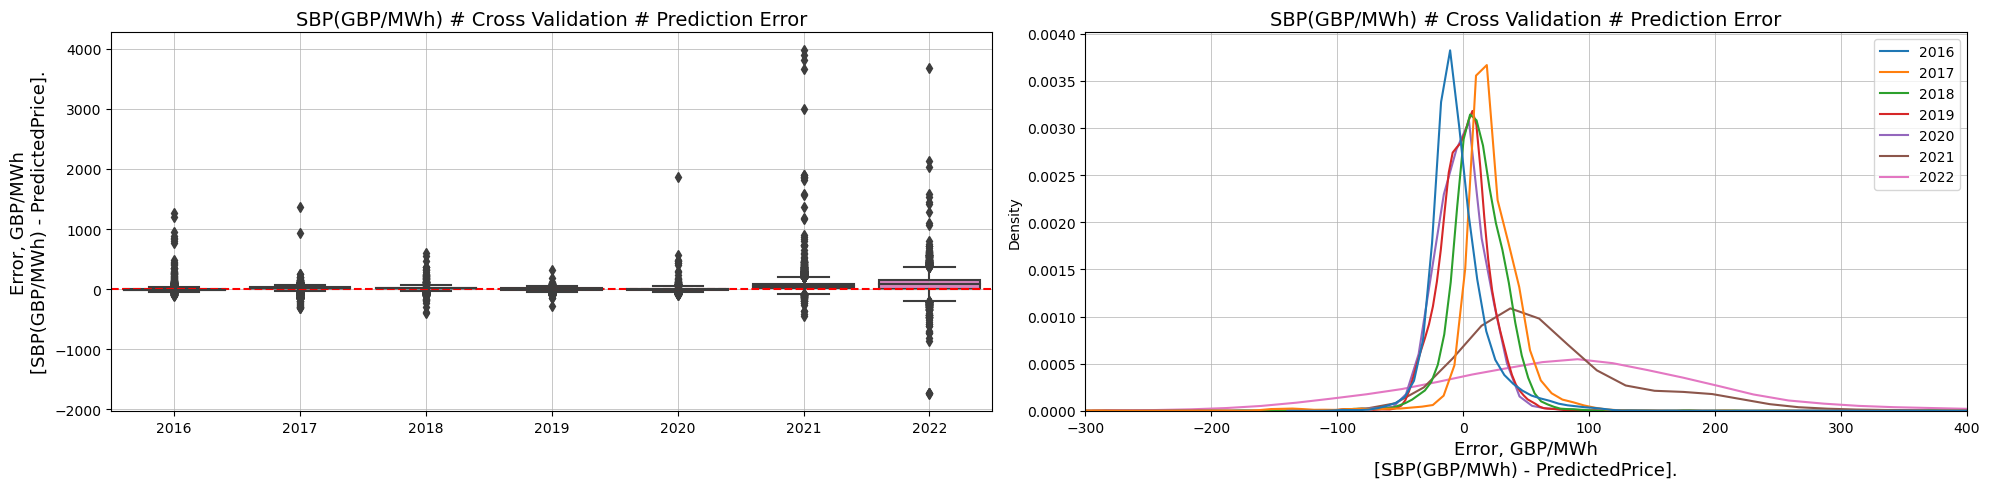

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.boxplot(ErrorDF,palette='tab10')
plt.title(f"{Target} # Cross Validation # Prediction Error",fontsize=14)
plt.ylabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=13)
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(which='both',linewidth = 0.5)
#
plt.subplot(1,2,2)
sns.kdeplot(ErrorDF,palette='tab10')
plt.title(f"{Target} # Cross Validation # Prediction Error",fontsize=14)
plt.xlabel(f"Error, GBP/MWh\n[{Target} - PredictedPrice].",fontsize=13)
plt.grid(which='both',linewidth = 0.5)
plt.xlim(-300,400)
plt.tight_layout()
plt.savefig(f"{path}/6_CV_Errors.png")

In [28]:
HourlyDF.loc[(HourlyDF['Year'] == 2019) & (HourlyDF['Month'] == 12) & (HourlyDF['Day'] == 26) & (HourlyDF['Hour'] == 18)]

,DATETIME,MC_StartingVolume,SBP(GBP/MWh),SSP(GBP/MWh),MID_APX_VOLUME(MWh),MID_APX_PRICE(GBP/MWh),MID_N2EX_VOLUME(MWh),MID_N2EX_PRICE(GBP/MWh),SSP_(GBP/MWh),NIV(MWh),...,Quarter,Month,Day,WeekNumber,DaysOfTheYear,DayOfTheWeek,Hour,Seasons,WeekDay_OR_Weekend,PublicHoliday
96282,2019-12-26 18:00:00+00:00,7867.3358,17.18,17.18,1185.525,40.305,0.0,0.0,17.18,-181.904,...,4,12,26,52,360,3,18,Winter,Weekday,Boxing Day


In [29]:
UniqueHolidays = set()
for key,value in AllHolidays.items():
    UniqueHolidays.add(value)
UniqueHolidays

{'Boxing Day',
 'Christmas Day',
 'Diamond Jubilee of Elizabeth II',
 'Easter Monday',
 'Good Friday',
 'Late Summer Bank Holiday',
 'May Day',
 'New Year Holiday',
 "New Year's Day",
 'Platinum Jubilee of Elizabeth II',
 'Spring Bank Holiday',
 "St. Andrew's Day",
 'State Funeral of Queen Elizabeth II',
 'Summer Bank Holiday',
 'Wedding of William and Catherine'}

In [30]:
len(UniqueHolidays)

15